In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("WARNING: CUDA not available. Running on CPU.")

![Alt text](image-1.png)

![Alt text](image.png)

In [3]:
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64

In [4]:
# Normalise data
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transform_test = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [5]:
# Create train, valid and test data
train_data = CelebA(root='./../../Fifth_Year/Sem2/COMP3710/data/celeba', 
                    split='train', download=False, transform=transform_train)
# test_data = CelebA(root='./../../Fifth_Year/Sem2/COMP3710/data/celeba', 
#                     split='test', download=False, transform=transform_test)

In [6]:
# Create random indices for train and test datasets
train_indices = torch.randperm(len(train_data))[:50000]
# test_indices = torch.randperm(len(test_data))[:2000]

# Create random subset of data
train_subset = Subset(train_data, train_indices)
# test_subset = Subset(test_data, test_indices)

In [7]:
# Setup batch size for train and test
batch_size_train = 128
# batch_size_test = 100

# Create DataLoader for train and test datasets
train_loader = DataLoader(train_subset, batch_size=batch_size_train, shuffle=True)
# test_loader = DataLoader(test_subset, batch_size=batch_size_test, shuffle=False)

In [8]:
print(f"Num Train Subset Samples: {len(train_subset)}")
# print(f"Num Test Subset Samples: {len(test_subset)}")

Num Train Subset Samples: 50000


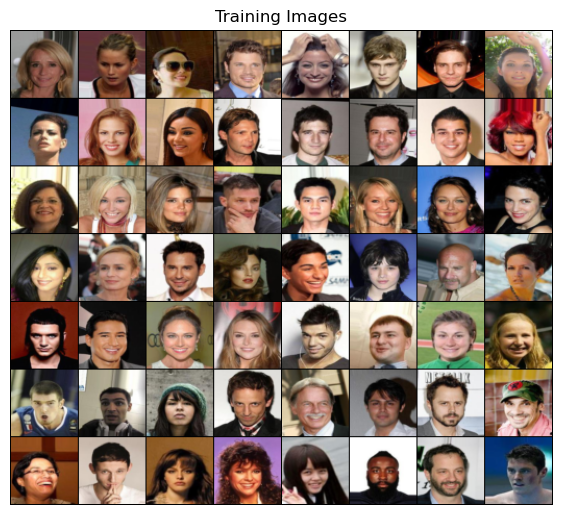

In [9]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:56], padding=1, normalize=True).cpu(),(1,2,0)))

# Generator Network

![Alt text](image-2.png)

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

# Discriminator Network

![Alt text](image-3.png)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [12]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [13]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

In [14]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [15]:
def show_tensor_images(image_tensor, num_images=32, size=(1, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Epoch [2/20] Batch 78/391                     Loss D: 0.4178, loss G: 1.9299


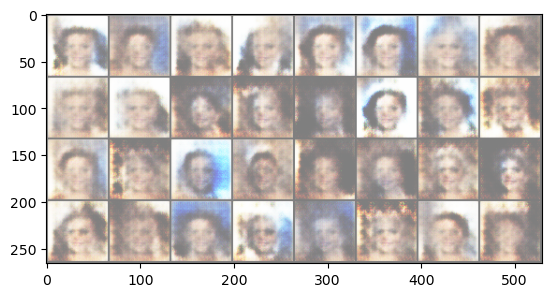

Epoch [4/20] Batch 78/391                     Loss D: 0.4248, loss G: 4.0993


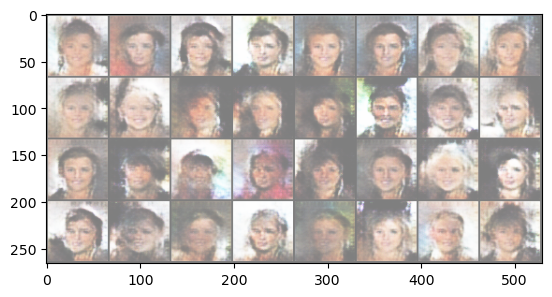

Epoch [6/20] Batch 78/391                     Loss D: 0.5272, loss G: 5.3377


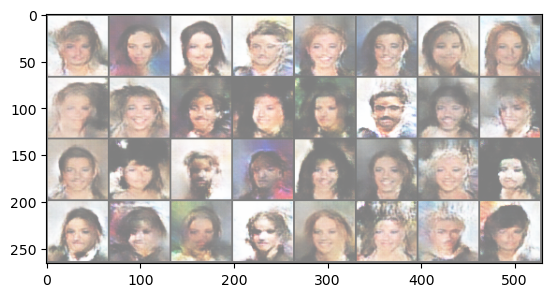

Epoch [8/20] Batch 78/391                     Loss D: 0.4617, loss G: 5.6125


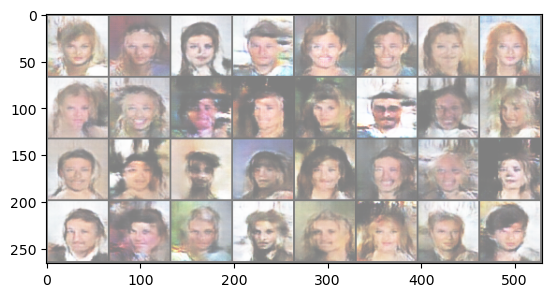

Epoch [10/20] Batch 78/391                     Loss D: 0.1949, loss G: 3.8583


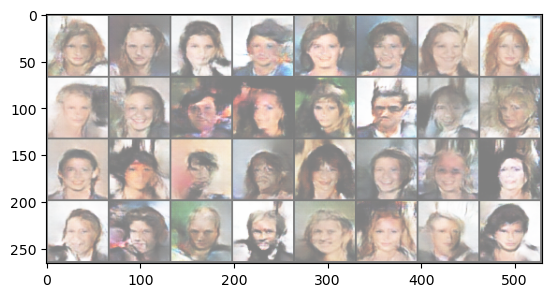

Epoch [12/20] Batch 78/391                     Loss D: 0.2912, loss G: 1.3482


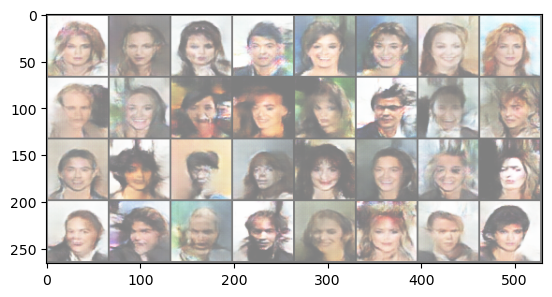

Epoch [14/20] Batch 78/391                     Loss D: 0.4289, loss G: 5.9402


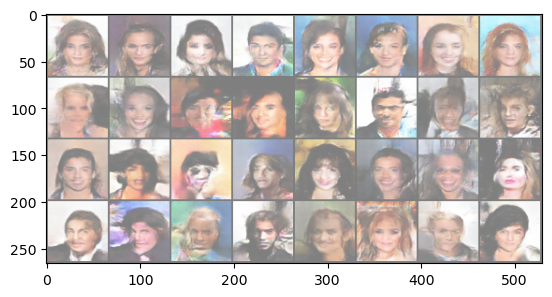

Epoch [16/20] Batch 78/391                     Loss D: 0.1808, loss G: 2.9514


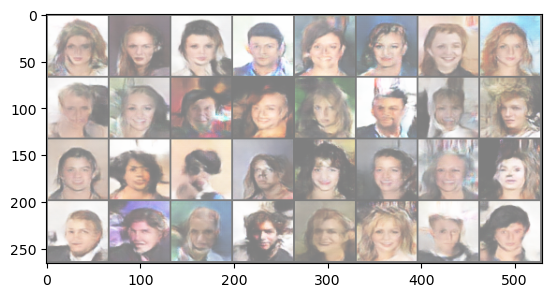

Epoch [18/20] Batch 78/391                     Loss D: 0.2099, loss G: 5.3762


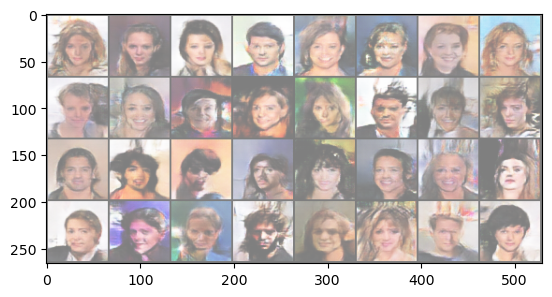

Epoch [20/20] Batch 78/391                     Loss D: 0.1719, loss G: 2.9554


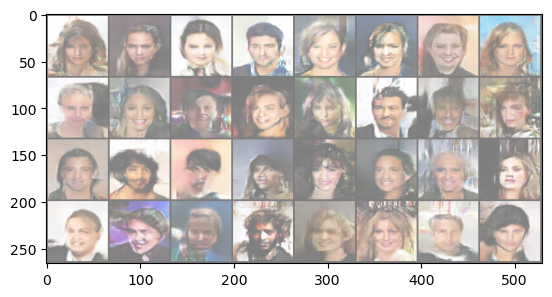

In [16]:
gen.train()
disc.train()

for epoch in range(1, NUM_EPOCHS+1):
    for batch_idx, (real, _ ) in enumerate(train_loader):
        real = real.to(device)
        ### create noise tensor
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### Print losses occasionally and fake images occasionally
        if (epoch % 2 == 0) and (batch_idx == 78):
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                    Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                show_tensor_images(img_grid_fake)